# UNet

In [2]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

In [3]:
(x_train,x_test) , (x_test,y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
y_train_seg = (x_train.mean(axis=-1)>0.5).astype(int)
y_test_seg = (x_test.mean(axis=-1)>0.5).astype(int)

In [7]:
y_train_seg = y_train_seg[:,:,:,np.newaxis] 
y_test_seg = y_test_seg[:,:,:,np.newaxis]

In [8]:
from tensorflow.keras import layers

In [13]:
def unet_model(input_size=(32,32,3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    p1 = layers.MaxPooling2D(2,2)(c1)
    c2 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(p1)
    p2 = layers.MaxPooling2D(2,2)(c2)

    c3 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(p2)

    u1 = layers.UpSampling2D((2,2))(c3)
    m1 = layers.concatenate([u1,c2])
    c4 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(u1)
    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.concatenate([u2,c1])
    c5 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(u2)

    outputs = layers.Conv2D(1,(1,1),activation='sigmoid')(c5)
    return tf.keras.Model(inputs,outputs)

In [15]:
model = unet_model()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
model.fit(x_train,y_train_seg,validation_data=(x_test,y_test_seg),epochs=5,batch_size=32)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 237s 151ms/step - accuracy: 0.9661 - loss: 0.0783 - val_accuracy: 0.9668 - val_loss: 0.0762
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 224s 143ms/step - accuracy: 0.9684 - loss: 0.0732 - val_accuracy: 0.9705 - val_loss: 0.0682
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 142ms/step - accuracy: 0.9709 - loss: 0.0676 - val_accuracy: 0.9716 - val_loss: 0.0658
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 142ms/step - accuracy: 0.9728 - loss: 0.0634 - val_accuracy: 0.9738 - val_loss: 0.0609
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 231s 148ms/step - accuracy: 0.9744 - loss: 0.0599 - val_accuracy: 0.9755 - val_loss: 0.0572


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


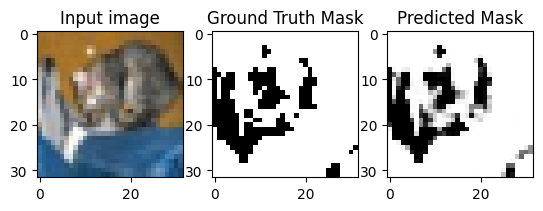

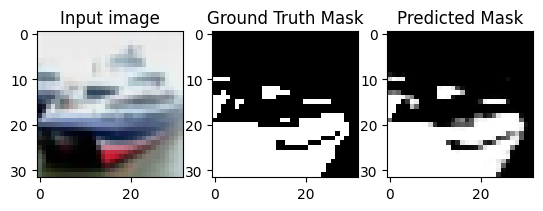

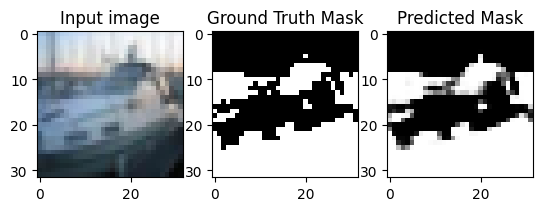

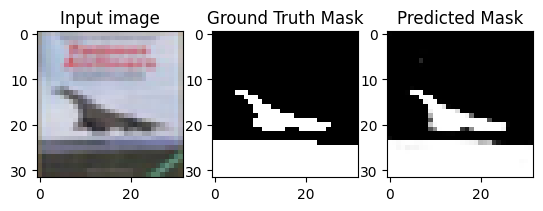

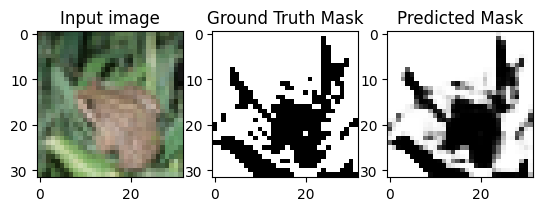

In [21]:
import matplotlib.pyplot as plt

pred = model.predict(x_test[:5])

for i in range(5):
    plt.subplot(1,3,1)
    plt.title("Input image")
    plt.imshow(x_test[i])

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_test_seg[i].squeeze(),cmap='Greys')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred[i].squeeze(),cmap='Greys')
    plt.show()

# FasterRCNN

In [22]:
import torch
import cv2
import numpy as np

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image

import torchvision.transforms as T

In [24]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
image_path = '/kaggle/input/stanford-dogs-dataset/images/Images/n02086910-papillon/n02086910_10204.jpg'
image = Image.open(image_path).convert('RGB')
transform = T.Compose([
    T.ToTensor()
])
image_tensor = transform(image)

In [27]:
with torch.no_grad():
    pred = model([image_tensor])

In [30]:
boxes = pred[0]['boxes']
labels = pred[0]['labels']
scores = pred[0]['scores']
image_np = np.array(image)
confidence_threshold = 0.5

In [34]:
for i,box in enumerate(boxes):
    if scores[i] > confidence_threshold:
        x1,y1,x2,y2 = map(int,box)
        label = labels[i].item()
        score = scores[i].item()

        cv2.rectangle(image_np,(x1,y1),(x2,y2),(0,255,0),2)
        text = f"Class: {label}, Score:{score:.2f}"
        cv2.putText(image_np,text,(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)

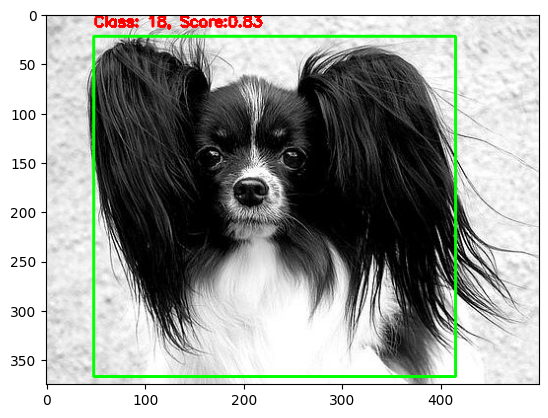

In [35]:
plt.imshow(image_np)
plt.show()